<a href="https://www.kaggle.com/code/ravaghi/fake-news-classification-lstm?scriptVersionId=166235786" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import random
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.corpus import stopwords
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None

In [2]:
# For reproducibility
seed = 27

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# Hyperparameters
vocab_size = 160_000
embedding_dim = 300
hidden_dim = 128
n_layers = 2
seq_len = 2000
learning_rate = 0.0025
max_epochs = 10
batch_size = 40

# Loading Data

In [4]:
train_ds = pd.read_csv("/kaggle/input/fake-news/train.csv")
test_ds = pd.read_csv("/kaggle/input/fake-news/test.csv")

# Used for creating the submission file later on
test_ds_ids = test_ds['id']

train_ds.shape, test_ds.shape

((20800, 5), (5200, 4))

In [5]:
def create_new_text(row):
    return "Author(s): " + row["author"] + "\n" + "Title: " + row["title"] + "\n\n" + row["text"]


train_ds["author"] = train_ds["author"].fillna("")
train_ds["title"] = train_ds["title"].fillna("")
train_ds["text"] = train_ds["text"].fillna("")
train_ds["new_text"] = train_ds.apply(create_new_text, axis=1)

test_ds["author"] = test_ds["author"].fillna("")
test_ds["title"] = test_ds["title"].fillna("")
test_ds["text"] = test_ds["text"].fillna("")
test_ds["new_text"] = test_ds.apply(create_new_text, axis=1)

In [6]:
dataset = train_ds.sample(frac=1).reset_index(drop=True)

train = dataset[:int(0.95 * len(dataset))]
val = dataset[int(0.95 * len(dataset)):]
test = test_ds

train.shape, val.shape, test.shape

((19760, 6), (1040, 6), (5200, 5))

# Processing the Dataset and Creating Dataloaders

In [7]:
def build_vocabulary():
    train_iterator = list(zip(train['new_text'], train['label']))
    tokenizer = get_tokenizer("basic_english")

    def tokenizer_fn(data_iterator):
        for text, _ in data_iterator:
            yield tokenizer(text)

    vocab = build_vocab_from_iterator(
        tokenizer_fn(train_iterator),
        specials=["<unk>"],
        max_tokens=vocab_size)
    vocab.set_default_index(vocab["<unk>"])

    return vocab, tokenizer


def clean_text(dataframe):
    stop_words = list(set(stopwords.words('english')))

    def _process_text(text):
        text = text.lower()
        text = " ".join([word for word in text.split() if word not in stop_words])
        text = re.sub(r"[^\w\s]", '', text)
        return text

    dataframe['new_text'] = dataframe['new_text'].apply(_process_text)

    return dataframe


def tokenize_text(dataframe, vocab, tokenizer):
    dataframe["new_text"] = dataframe["new_text"].apply(lambda x: np.array(vocab(tokenizer(x)), dtype=np.int64))
    if "label" in dataframe.columns:
        return dataframe[['new_text', 'label']]
    return dataframe[['new_text']]


def pad_tokens(dataframe, vocab, max_len):
    dataframe['new_text'] = dataframe['new_text'].apply(
        lambda x: np.pad(x, (0, max(0, max_len - len(x))), 'constant', constant_values=vocab["<unk>"]))
    dataframe["new_text"] = dataframe["new_text"].apply(
        lambda x: x[:max_len])
    return dataframe


def create_dataloader(dataframe, vocab, tokenizer, seq_len, batch_size):
    dataframe = clean_text(dataframe)
    dataframe = tokenize_text(dataframe, vocab, tokenizer)
    dataframe = pad_tokens(dataframe=dataframe, vocab=vocab, max_len=seq_len)

    if "label" in dataframe.columns:
        dataset = TensorDataset(
            torch.from_numpy(np.vstack(dataframe["new_text"].values)),
            torch.from_numpy(dataframe["label"].values)
        )
    else:
        dataset = TensorDataset(
            torch.from_numpy(np.vstack(dataframe["new_text"].values))
        )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=2
    )

In [8]:
vocab, tokenizer = build_vocabulary()

train_dataloader = create_dataloader(
    dataframe=train,
    vocab=vocab,
    tokenizer=tokenizer,
    seq_len=seq_len,
    batch_size=batch_size
)

val_dataloader = create_dataloader(
    dataframe=val,
    vocab=vocab,
    tokenizer=tokenizer,
    seq_len=seq_len,
    batch_size=batch_size
)

test_dataloader = create_dataloader(
    dataframe=test,
    vocab=vocab,
    tokenizer=tokenizer,
    seq_len=seq_len,
    batch_size=batch_size
)

# Creating Model and Trainer

In [9]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, seq_len):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True
        )
        self.fc = nn.Linear(seq_len * hidden_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = torch.reshape(x, (x.size(0), -1,))
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

In [10]:
class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader, test_dataloader, device, criterion, optimizer):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer

    def train(self, current_epoch_nr):
        self.model.train()

        num_batches = len(self.train_dataloader)

        preds = []
        targets = []
        correct = 0
        running_loss = 0.0
        items_processed = 0

        loop = tqdm(enumerate(self.train_dataloader), total=num_batches)
        for idx, (x, y) in loop:
            x = x.to(self.device)
            y = y.to(self.device)

            y_hat = self.model(x)

            loss = self.criterion(y_hat, y)
            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()

            running_loss += loss.item()

            _, predicted = y_hat.max(1)
            items_processed += y.size(0)
            correct += predicted.eq(y).sum().item()

            targets.extend(y.detach().cpu().numpy().flatten())
            preds.extend(predicted.detach().cpu().numpy().flatten())

            loop.set_description(f'Epoch {current_epoch_nr + 1}')
            loop.set_postfix(
                train_acc=round(correct / items_processed, 4),
                train_loss=round(running_loss / items_processed, 4)
            )

        train_auc = metrics.roc_auc_score(targets, preds)
        train_accuracy = correct / items_processed
        train_loss = running_loss / items_processed

        return train_auc, train_accuracy, train_loss

    def evaluate(self, current_epoch_nr, scheduler):
        self.model.eval()

        num_batches = len(self.val_dataloader)

        preds = []
        targets = []
        correct = 0
        running_loss = 0.0
        items_processed = 0

        with torch.no_grad():
            loop = tqdm(enumerate(self.val_dataloader), total=num_batches)
            for idx, (x, y) in loop:
                x = x.to(self.device)
                y = y.to(self.device)

                y_hat = self.model(x)

                loss = self.criterion(y_hat, y)

                running_loss += loss.item()

                _, predicted = y_hat.max(1)
                items_processed += y.size(0)
                correct += predicted.eq(y).sum().item()

                targets.extend(y.detach().cpu().numpy().flatten())
                preds.extend(predicted.detach().cpu().numpy().flatten())

                loop.set_description(f'Epoch {current_epoch_nr + 1}')
                loop.set_postfix(
                    val_acc=round(correct / items_processed, 4),
                    val_loss=round(running_loss / items_processed, 4)
                )

        val_auc = metrics.roc_auc_score(targets, preds)
        validation_accuracy = correct / items_processed
        validation_loss = running_loss / num_batches

        scheduler.step(validation_accuracy)

        return val_auc, validation_accuracy, validation_loss

    def predict(self):
        self.model.eval()

        num_batches = len(self.test_dataloader)

        preds = []

        with torch.no_grad():
            loop = tqdm(enumerate(self.test_dataloader), total=num_batches)
            for idx, x in loop:
                x = x[0].to(self.device)
                y_hat = self.model(x)
                _, predicted = y_hat.max(1)
                preds.extend(predicted.detach().cpu().numpy().flatten())

        return preds

# Training

In [11]:
device = "cuda:0"

model = LSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    seq_len=seq_len
).to(device)

class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train["label"])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = CrossEntropyLoss(weight=class_weights, reduction="mean")
optimizer = Adam(lr=learning_rate, params=model.parameters())
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    criterion=criterion,
    optimizer=optimizer
)

train_aucs = []
train_accs = []
train_losses = []

val_aucs = []
val_accs = []
val_losses = []

for epoch in range(max_epochs):
    train_auc, train_accuracy, train_loss = trainer.train(
        current_epoch_nr=epoch)
    train_aucs.append(train_auc)
    train_accs.append(train_accuracy)
    train_losses.append(train_loss)

    val_auc, val_accuracy, val_loss = trainer.evaluate(
        current_epoch_nr=epoch, scheduler=scheduler)
    val_aucs.append(val_auc)
    val_accs.append(val_accuracy)
    val_losses.append(val_loss)

Epoch 10: 100%|██████████| 26/26 [00:00<00:00, 28.16it/s, val_acc=0.995, val_loss=0.0004]


# Plotting Training History

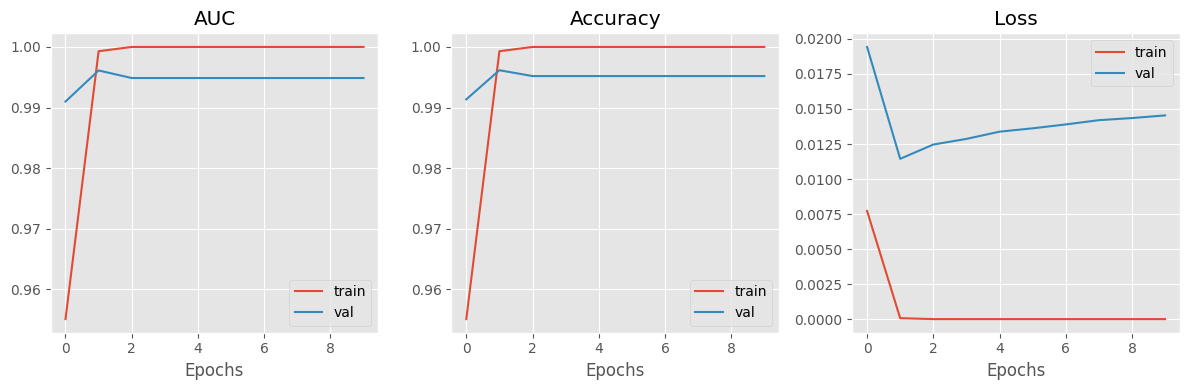

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(train_aucs, label='train')
axs[0].plot(val_aucs, label='val')
axs[0].set_xlabel('Epochs')
axs[0].set_title('AUC')
axs[0].legend()

axs[1].plot(train_accs, label='train')
axs[1].plot(val_accs, label='val')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Accuracy')
axs[1].legend()

axs[2].plot(train_losses, label='train')
axs[2].plot(val_losses, label='val')
axs[2].set_xlabel('Epochs')
axs[2].set_title('Loss')
axs[2].legend()

plt.tight_layout()
plt.show()

# Creating Submission

In [13]:
predictions = trainer.predict()
submission = pd.DataFrame({'id': test_ds_ids, 'label': predictions})
submission.to_csv('submission.csv', index=False)
submission.head()

100%|██████████| 130/130 [00:04<00:00, 31.52it/s]


,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
